In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import optuna
from sklearn.model_selection import cross_val_score


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

train_data = pd.merge(training_set_values, training_set_labels, on='id')
train_df=train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')
test_df = test_set_values.copy()

In [6]:
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Columns to drop, dropping num_private because 58643 out of 59400 column have value zero
# date_recorded is changed because we feature engineered it to raininess_score
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by', 'num_private']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Function to assign raininess score by month
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Globals for label encoding
categorical_cols = []
encoders = {}

# 1. Preprocessing + Encoding (Label Encoding only)
def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    df = df.copy()

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# 2. Model Building using Logistic Regression
def build_model_label(train_df, data_proportion=1.0, random_state=42):
    train_df = clean_encode_label(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = LogisticRegression(max_iter=1000, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# 3. Predict on Test Set
def predict_test_set_label(model_data, test_df):
    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_7252\1082836237.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

Model trained on 100.0% of data
Accuracy: 0.5652
Classification Report:
                         precision    recall  f1-score   support

             functional       0.57      0.87      0.69      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.53      0.24      0.33      4565

               accuracy                           0.57     11880
              macro avg       0.37      0.37      0.34     11880
           weighted avg       0.52      0.57      0.50     11880



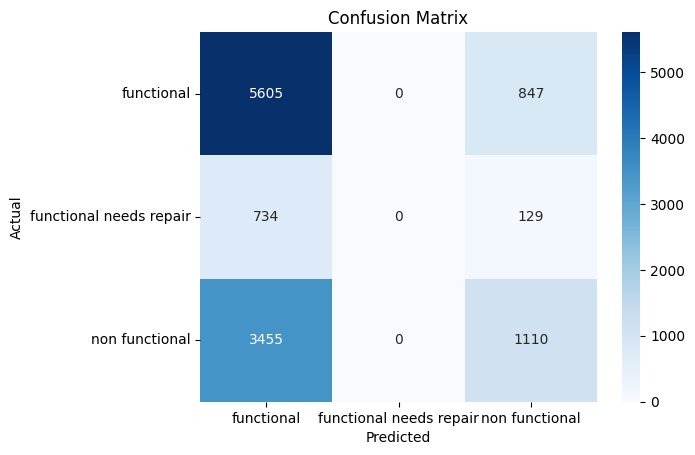

{'model': LogisticRegression(max_iter=1000, random_state=42)}

In [7]:
build_model_label(train_df)